# Classification framework

Two steps are required
- Model selection, i.e. find the optimal hyperparemeters,
- Model assessement, i.e. validate the model on unseen data.

Scikit-learn offers convenient and generic functions to achieve these steps. In what follow, an example is given for SVM. But it can be extended for any algorithm in scikit-learn, up to a correct definition of the hyperparameters. In this labworks, we use the support vector classifier (SVC) (http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) on the digit data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits as load
import scipy as sp
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Load
X, y = load(return_X_y=True)
print("Number of samples: {}".format(X.shape[0]))

Number of samples: 1797


In [2]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=1000, n_features=50, n_informative=40, n_redundant=10,
                          n_classes=10, n_clusters_per_class=1)

With kernel methods (and more generaly for any distance based methods), it is a good practice to standardize feature remove dynamics effect. Here we rescale each feature between 0 and 1. This step can be done inside or outside the cross validation loop, since it is does not depende on the label, it does not matter.

In [3]:
# Standardize data
sc = MinMaxScaler()
X = sc.fit_transform(X) # Scale data between 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0, stratify=y)

In this notebooks, three kernels will be investigated:
- A linear kernel, in that case, there is only one hyperparameter to tune (regularization).
- A polynomial kernel, in that case, there are two parameters to tune (regularization + order)
- A Gaussian kernel, in that case, tere are two parameters to tune (regularization + scale)

In [4]:
degree = sp.arange(0,4) # Degree of the polynomial kernel
C = 10.0**sp.arange(-1,3) # Penality of the optimization problem
gamma = 2.0**sp.arange(-4,4) # Scale of the RBF kernel
params = [dict(kernel=['linear'], C=C),
          dict(kernel=['poly'],degree=degree, C=C),
          dict(kernel=['rbf'],gamma=gamma, C=C)]

It is possible to run all in once, but for illustrative purpose, we apply the CV for each classifier.

In [5]:
for clf, params_ in zip(['Linear', 'Poly', 'Gaussian'], params):
    print("Classifier {}".format(clf))
    grid = GridSearchCV(SVC(),  # Set up the classifier
                    param_grid=params_, 
                    cv= 3,
                    n_jobs=-1) # Do the grid search in parallel
    grid.fit(X_train, y_train) # Run the grid search

    # Print some results
    print("Best score: {}".format(grid.best_score_)) # Default scorer in scikit is the correct classification rate
    print("Best set of hyperparameters: {}".format(grid.best_params_))
    
    # Learn the optimal model
    clf = grid.best_estimator_  # Get the best estimator
    clf.fit(X_train,y_train)  # Fit it using the training set
    
    # Predict new samples
    y_pred = clf.predict(X_test)

    # Compute the overall accuracies
    print("Correct classification rate on the test set: {}\n".format(accuracy_score(y_test,y_pred)))

Classifier Linear
Best score: 0.6373333333333333
Best set of hyperparameters: {'C': 10.0, 'kernel': 'linear'}
Correct classification rate on the test set: 0.664

Classifier Poly
Best score: 0.652
Best set of hyperparameters: {'C': 100.0, 'degree': 1, 'kernel': 'poly'}
Correct classification rate on the test set: 0.696

Classifier Gaussian
Best score: 0.7826666666666666
Best set of hyperparameters: {'C': 10.0, 'kernel': 'rbf', 'gamma': 2.0}
Correct classification rate on the test set: 0.836



We can plot the correct classification rate function of the hyperparameters. It is important to check if our search values are correct.

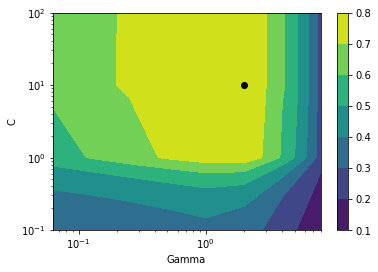

In [6]:
res = grid.cv_results_['mean_test_score'].reshape(C.size,gamma.size)
X, Y = sp.meshgrid(gamma, C)
fig, ax = plt.subplots(1,1)
cp = ax.contourf(X, Y, res)
ax.scatter(grid.best_params_['gamma'],grid.best_params_['C'],color='k')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Gamma")
ax.set_ylabel("C")
fig.colorbar(cp)